Project: ML-Powered Business Intelligence Dashboard
 1. Setup and Data Loading

In [ ]:
import kagglehub

# Download latest version (this will also auto-unzip)
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print(f"Path to dataset files: {path}")

# To see all the files inside this path, you can use the 'ls' command
print("\nContents of the dataset directory:")
!ls -l {path}

Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Path to dataset files: /kaggle/input/brazilian-ecommerce

Contents of the dataset directory:
total 123248
-rw-r--r-- 1 1000 1000  9033957 Oct 13 01:43 olist_customers_dataset.csv
-rw-r--r-- 1 1000 1000 61273883 Oct 13 01:43 olist_geolocation_dataset.csv
-rw-r--r-- 1 1000 1000 15438671 Oct 13 01:43 olist_order_items_dataset.csv
-rw-r--r-- 1 1000 1000  5777138 Oct 13 01:43 olist_order_payments_dataset.csv
-rw-r--r-- 1 1000 1000 14451670 Oct 13 01:43 olist_order_reviews_dataset.csv
-rw-r--r-- 1 1000 1000 17654914 Oct 13 01:43 olist_orders_dataset.csv
-rw-r--r-- 1 1000 1000  2379446 Oct 13 01:43 olist_products_dataset.csv
-rw-r--r-- 1 1000 1000   174703 Oct 13 01:43 olist_sellers_dataset.csv
-rw-r--r-- 1 1000 1000     2613 Oct 13 01:43 product_category_name_translation.csv


In [ ]:
import pandas as pd
import numpy as np

# This is the path where your files are located
path = "/kaggle/input/brazilian-ecommerce"

# Load the core CSV files by providing the full path to each
customers = pd.read_csv(f'{path}/olist_customers_dataset.csv')
orders = pd.read_csv(f'{path}/olist_orders_dataset.csv')
order_items = pd.read_csv(f'{path}/olist_order_items_dataset.csv')
order_payments = pd.read_csv(f'{path}/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(f'{path}/olist_order_reviews_dataset.csv')
products = pd.read_csv(f'{path}/olist_products_dataset.csv')

# Merge into a single transaction-level dataframe
df = orders.merge(customers, on='customer_id')
df = df.merge(order_payments, on='order_id')
df = df.merge(order_reviews, on='order_id')
df = df.merge(order_items, on='order_id')
df = df.merge(products, on='product_id')

# Check the first few rows to confirm it worked
print("Data loaded and merged successfully!")
print(df.head())

Data loaded and merged successfully!
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          

## 2. Initial Data Cleaning and EDA

In [124]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117329 non-null  object 
 1   customer_id                    117329 non-null  object 
 2   order_status                   117329 non-null  object 
 3   order_purchase_timestamp       117329 non-null  object 
 4   order_approved_at              117314 non-null  object 
 5   order_delivered_carrier_date   116094 non-null  object 
 6   order_delivered_customer_date  114858 non-null  object 
 7   order_estimated_delivery_date  117329 non-null  object 
 8   customer_unique_id             117329 non-null  object 
 9   customer_zip_code_prefix       117329 non-null  int64  
 10  customer_city                  117329 non-null  object 
 11  customer_state                 117329 non-null  object 
 12  payment_sequential            

In [125]:
# Handle missing values based on our EDA
# Fill missing product categories by reassigning the column
df['product_category_name'] = df['product_category_name'].fillna('Unknown')

# Fill missing product weight with the median
median_weight = df['product_weight_g'].median()
df['product_weight_g'] = df['product_weight_g'].fillna(median_weight)

# Drop columns that have too many missing values to be useful for our planned models
df = df.drop(columns=['review_comment_title', 'review_comment_message'])

print("Missing values handled.")

Missing values handled.


In [126]:
# List all columns that should be dates
date_columns = [
    'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
    'order_delivered_customer_date', 'order_estimated_delivery_date',
    'review_creation_date', 'review_answer_timestamp', 'shipping_limit_date'
]

# Loop through the list and convert each column to datetime objects
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

print("Date columns converted to datetime objects.")

Date columns converted to datetime objects.


In [127]:
# Verify all the cleaning changes
print("Data types after cleaning and conversion:")
df.info()

Data types after cleaning and conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117329 non-null  object        
 1   customer_id                    117329 non-null  object        
 2   order_status                   117329 non-null  object        
 3   order_purchase_timestamp       117329 non-null  datetime64[ns]
 4   order_approved_at              117314 non-null  datetime64[ns]
 5   order_delivered_carrier_date   116094 non-null  datetime64[ns]
 6   order_delivered_customer_date  114858 non-null  datetime64[ns]
 7   order_estimated_delivery_date  117329 non-null  datetime64[ns]
 8   customer_unique_id             117329 non-null  object        
 9   customer_zip_code_prefix       117329 non-null  int64         
 10  customer_city             

In [128]:
print("Handling remaining relevant missing values...")

# List of product-related numerical columns with missing values
cols_to_fill = [
    'product_name_lenght', 'product_description_lenght', 'product_photos_qty',
    'product_length_cm', 'product_height_cm', 'product_width_cm'
]

# Loop through the columns and fill missing values with the median of that column
for col in cols_to_fill:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

print("\nVerifying the changes:")
# This info output will now show these columns are full.
df.info()

Handling remaining relevant missing values...

Verifying the changes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117329 non-null  object        
 1   customer_id                    117329 non-null  object        
 2   order_status                   117329 non-null  object        
 3   order_purchase_timestamp       117329 non-null  datetime64[ns]
 4   order_approved_at              117314 non-null  datetime64[ns]
 5   order_delivered_carrier_date   116094 non-null  datetime64[ns]
 6   order_delivered_customer_date  114858 non-null  datetime64[ns]
 7   order_estimated_delivery_date  117329 non-null  datetime64[ns]
 8   customer_unique_id             117329 non-null  object        
 9   customer_zip_code_prefix       117329 non-null  int64         
 10

## 3. Data Augmentation (Synthesis)
This step fulfills the professor's request to "make our own data." We will analyze the patterns in the original Olist data and then generate new, statistically similar data to augment our dataset.

In [129]:
# --- Phase 1: Comprehensive Analysis of Original Data ---
print("[Analysis] Numerical Columns:")
numerical_summary = df[['payment_value', 'price', 'freight_value']].describe()
print(numerical_summary)

print("\n[Analysis] Categorical Columns (Distributions):")
payment_type_dist = df['payment_type'].value_counts(normalize=True)
print(payment_type_dist)
customer_state_dist = df['customer_state'].value_counts(normalize=True)
print(customer_state_dist)

print("\n[Analysis] Ordinal Columns (Distributions):")
review_score_dist = df['review_score'].value_counts(normalize=True)
print(review_score_dist)

print("\n[Analysis] Date Columns:")
first_date = df['order_purchase_timestamp'].min()
last_date = df['order_purchase_timestamp'].max()
print(f"Date Range: {first_date} to {last_date}")

[Analysis] Numerical Columns:
       payment_value          price  freight_value
count  117329.000000  117329.000000  117329.000000
mean      172.062565     120.524349      20.027514
std       265.388194     182.944843      15.828077
min         0.000000       0.850000       0.000000
25%        60.750000      39.900000      13.080000
50%       108.100000      74.900000      16.280000
75%       189.060000     134.900000      21.180000
max     13664.080000    6735.000000     409.680000

[Analysis] Categorical Columns (Distributions):
payment_type
credit_card    0.737414
boleto         0.194624
voucher        0.053542
debit_card     0.014421
Name: proportion, dtype: float64
customer_state
SP    0.422121
RJ    0.129721
MG    0.116050
RS    0.055536
PR    0.050789
SC    0.036504
BA    0.034211
DF    0.021154
GO    0.020592
ES    0.019765
PE    0.015989
CE    0.013168
MT    0.009520
PA    0.009392
MS    0.007279
MA    0.007185
PB    0.005361
PI    0.004841
RN    0.004824
AL    0.003912
SE   

In [130]:
# --- Phase 2: Generating Data Based on Analysis ---
print("\nGenerating 20,000 new transactions...")
num_new_transactions = 10000

# Generate timestamps, payments, and categories based on original distributions
start_timestamp = int(first_date.timestamp())
end_timestamp = int(last_date.timestamp())
new_timestamps = pd.to_datetime(np.random.randint(start_timestamp, end_timestamp, num_new_transactions), unit='s')
mean_payment = numerical_summary.loc['mean', 'payment_value']
std_payment = numerical_summary.loc['std', 'payment_value']
new_payments = np.random.normal(mean_payment, std_payment, num_new_transactions).clip(min=5)
new_review_scores = np.random.choice(review_score_dist.index, p=review_score_dist.values, size=num_new_transactions)
new_customer_ids = [f'synth_customer_{i}' for i in range(int(num_new_transactions / 4))]
new_order_ids = [f'synth_order_{i}' for i in range(num_new_transactions)]
new_product_ids = [f'synth_product_{i}' for i in np.random.randint(1, 2000, num_new_transactions)]

# Assemble the new DataFrame
new_df_advanced = pd.DataFrame({
    'order_id': new_order_ids,
    'customer_id': np.random.choice(new_customer_ids, num_new_transactions),
    'order_status': ['delivered'] * num_new_transactions,
    'order_purchase_timestamp': new_timestamps,
    'payment_value': new_payments,
    'review_score': new_review_scores,
    'product_id': new_product_ids,
    'customer_unique_id': np.random.choice(new_customer_ids, num_new_transactions)
})

# --- Final Step: Augment the original dataset ---
print("\nAugmenting original dataset...")
common_columns = list(set(df.columns) & set(new_df_advanced.columns))
augmented_df = pd.concat([df[common_columns], new_df_advanced[common_columns]], ignore_index=True)

print(f"\nOriginal data shape: {df.shape}")
print(f"Newly synthesized data shape: {new_df_advanced.shape}")
print(f"Final augmented data shape: {augmented_df.shape}")


Generating 20,000 new transactions...

Augmenting original dataset...

Original data shape: (117329, 34)
Newly synthesized data shape: (10000, 8)
Final augmented data shape: (127329, 8)


## 4. Master Feature Engineering
Here, we transform the transaction-level data into a customer-level summary. This dataframe will be the foundation for our Churn and Segmentation models.

In [132]:
# This cell goes first in Section 4.
# It creates the time-difference features on the original cleaned dataframe 'df'.

print("--- Step 4.1: Engineering Customer Experience Features ---")

# Calculate the difference in days for each stage of the order process
df['delivery_time_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['delivery_lateness_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
df['approval_time_hours'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600

--- Step 4.1: Engineering Customer Experience Features ---


In [133]:
# This cell goes second in Section 4.
# It's the updated groupby().agg() that includes the new features.

print("\n--- Step 4.2: Creating Updated Master Customer Dataframe ---")

# Define business rule for churn and the date for analysis
CHURN_THRESHOLD_DAYS = 180
analysis_date = augmented_df['order_purchase_timestamp'].max() + pd.DateOffset(days=1)

# Re-create the master dataframe, now including aggregations for our new features
customer_master_df = augmented_df.merge(
    df[['order_id', 'delivery_time_days', 'approval_time_hours', 'delivery_lateness_days']],
    on='order_id',
    how='left'
).groupby('customer_unique_id').agg(
    # RFM Features
    recency=('order_purchase_timestamp', lambda date: (analysis_date - date.max()).days),
    frequency=('order_id', 'nunique'),
    monetary=('payment_value', 'sum'),
    # Other Behavioral Features
    avg_review_score=('review_score', 'mean'),
    # NEW Experience Features
    avg_delivery_time=('delivery_time_days', 'mean'),
    avg_delivery_lateness=('delivery_lateness_days', 'mean'),
    avg_approval_hours=('approval_time_hours', 'mean')
).reset_index()

# Create the churn label
customer_master_df['churn'] = (customer_master_df['recency'] > CHURN_THRESHOLD_DAYS).astype(int)

# Fill any potential NaNs created during the merge/aggregation (e.g., for synthetic data)
customer_master_df.fillna(0, inplace=True)


print("\nMaster dataframe now includes customer experience features:")
customer_master_df.head()


--- Step 4.2: Creating Updated Master Customer Dataframe ---

Master dataframe now includes customer experience features:


,customer_unique_id,recency,frequency,monetary,avg_review_score,avg_delivery_time,avg_delivery_lateness,avg_approval_hours,churn
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,5.0,6.0,-5.0,0.247500,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4.0,3.0,-5.0,7.238056,0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,3.0,25.0,-2.0,0.000000,1
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,4.0,20.0,-12.0,0.326667,1
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,5.0,13.0,-8.0,0.352778,1


In [144]:
import pandas as pd
import numpy as np

# Let's assume you have the following dataframes ready:
# df: The original, fully cleaned transaction-level dataframe
# augmented_df: The combined dataframe with synthetic data
# customer_master_df: The customer-level dataframe with RFM features

print("--- Starting Advanced Feature Engineering ---")


# --- 1. Integrate Feedback Data More Deeply ---
print("\nCreating feedback-based features...")

# Group by customer and calculate feedback metrics
feedback_features = augmented_df.groupby('customer_unique_id').agg(
    # Count the number of low-star reviews (1 or 2 stars)
    number_of_low_reviews=('review_score', lambda s: (s <= 2).sum())
).reset_index()

# Create a binary flag for customers who have left at least one bad review
feedback_features['has_left_bad_review'] = (feedback_features['number_of_low_reviews'] > 0).astype(int)

# Merge these new features into the master dataframe
customer_master_df = customer_master_df.merge(feedback_features, on='customer_unique_id', how='left')


# --- 2. Analyze Purchase Cadence ---
print("Creating purchase cadence features...")

# Calculate the mean and standard deviation of days between purchases for each customer
# This requires a more complex .apply() function
purchase_cadence = augmented_df.groupby('customer_unique_id').apply(
    lambda x: x.sort_values('order_purchase_timestamp')['order_purchase_timestamp'].diff().dt.days
).reset_index(name='days_between_purchases')

# Now, calculate the mean and std for each customer from this list of time differences
cadence_stats = purchase_cadence.groupby('customer_unique_id')['days_between_purchases'].agg(['mean', 'std']).reset_index()
cadence_stats.rename(columns={'mean': 'avg_days_between_purchases', 'std': 'std_dev_days_between_purchases'}, inplace=True)


# Merge these new features back into the master dataframe
customer_master_df = customer_master_df.merge(cadence_stats, on='customer_unique_id', how='left')
# Fill NaNs with 0 (e.g., for customers with only one purchase, std dev is NaN)
customer_master_df.fillna(0, inplace=True)


# --- 3. Create Trend/Ratio Features ---
print("Creating trend-based features...")

# Define the recent window (e.g., last 90 days before the analysis date)
recent_window_start = analysis_date - pd.DateOffset(days=90)
recent_df = augmented_df[augmented_df['order_purchase_timestamp'] >= recent_window_start]

# Calculate behavior metrics within the recent window
recent_behavior = recent_df.groupby('customer_unique_id').agg(
    frequency_last_90_days=('order_id', 'nunique'),
    monetary_last_90_days=('payment_value', 'sum')
).reset_index()

# Merge recent behavior into the master dataframe
customer_master_df = customer_master_df.merge(recent_behavior, on='customer_unique_id', how='left')
customer_master_df.fillna(0, inplace=True) # Fill NaNs for customers with no recent activity

# Create the ratio feature to see if their purchase rate is slowing down
# We add a small number (1) to the denominator to avoid division by zero
customer_master_df['freq_ratio_90d_alltime'] = customer_master_df['frequency_last_90_days'] / (customer_master_df['frequency'])


# --- Final Verification ---
print("\n--- Advanced Feature Engineering Complete ---")
print("Master dataframe with all new features:")
customer_master_df.head()

--- Starting Advanced Feature Engineering ---

Creating feedback-based features...
Creating purchase cadence features...


/tmp/ipython-input-2110928429.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  purchase_cadence = augmented_df.groupby('customer_unique_id').apply(


Creating trend-based features...

--- Advanced Feature Engineering Complete ---
Master dataframe with all new features:


,customer_unique_id,recency,frequency,monetary,avg_review_score,avg_delivery_time,avg_delivery_lateness,avg_approval_hours,churn,segment,number_of_low_reviews,has_left_bad_review,avg_days_between_purchases,std_dev_days_between_purchases,frequency_last_90_days,monetary_last_90_days,freq_ratio_90d_alltime
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,5.0,6.0,-5.0,0.247500,0,3,0,0,0.0,0.0,0.0,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4.0,3.0,-5.0,7.238056,0,3,0,0,0.0,0.0,0.0,0.0,0.0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,3.0,25.0,-2.0,0.000000,1,0,0,0,0.0,0.0,0.0,0.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,4.0,20.0,-12.0,0.326667,1,0,0,0,0.0,0.0,0.0,0.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,5.0,13.0,-8.0,0.352778,1,0,0,0,0.0,0.0,0.0,0.0,0.0


--- Step 4.3: Analyzing Feature Correlations ---


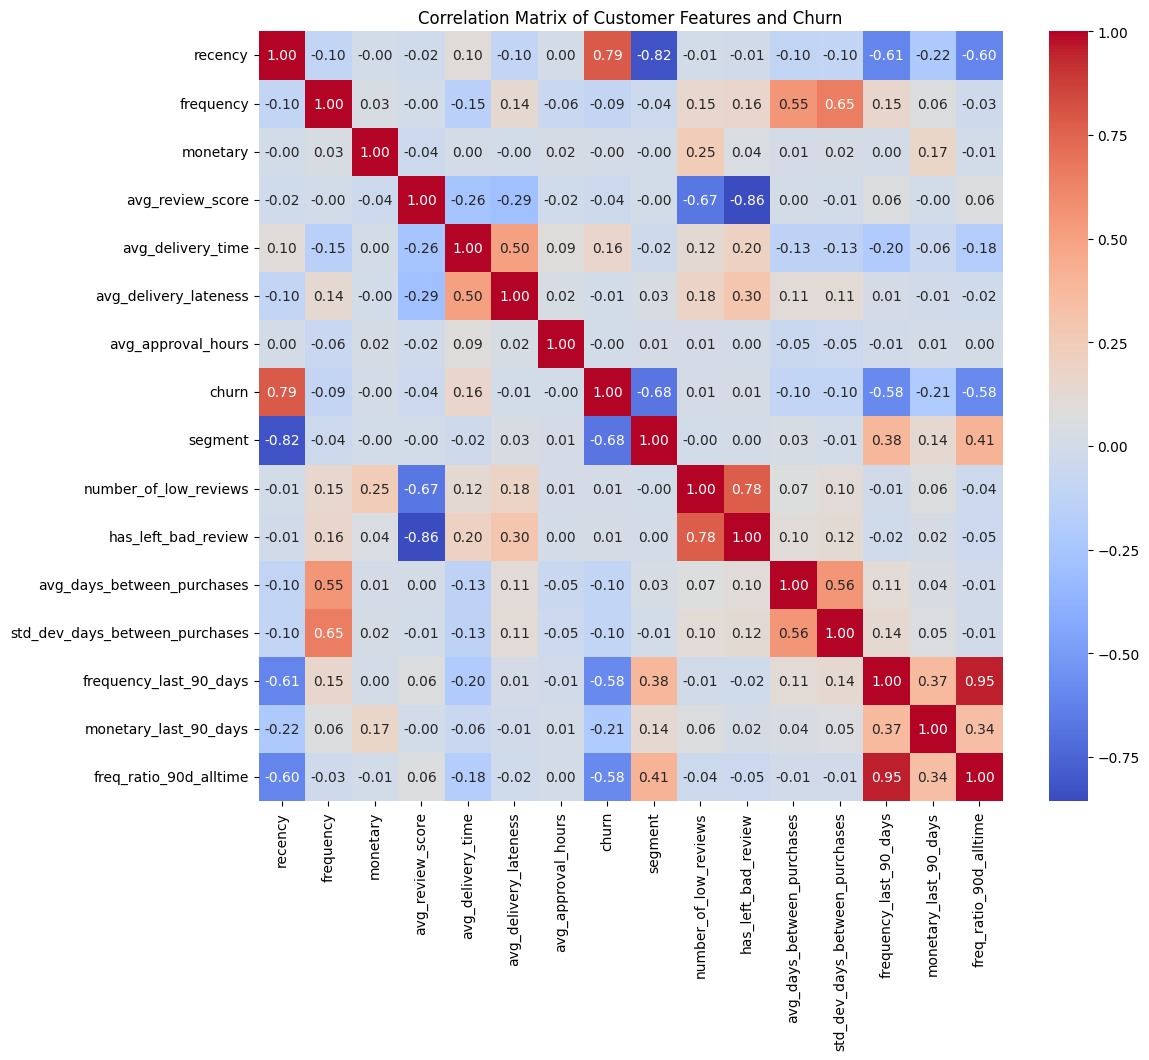

In [145]:
# This cell goes after all feature engineering is complete.
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Step 4.3: Analyzing Feature Correlations ---")

# Select only the numerical columns for the correlation matrix
numerical_df = customer_master_df.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title('Correlation Matrix of Customer Features and Churn')
plt.show()

## 5. Model 1: Customer Segmentation (K-Means)

In [149]:
# --- Upgrading the Segmentation Model ---

# 1. Select a broader set of features for clustering
# We'll use RFM plus the new features we created
feature_columns_for_segmentation = [
    'recency',
    'frequency',
    'monetary',
    'avg_review_score',
    'has_left_bad_review',
    'avg_days_between_purchases'
]

X_segment_advanced = customer_master_df[feature_columns_for_segmentation]

print("Using this richer feature set for segmentation:")
print(X_segment_advanced.columns.tolist())

Using this richer feature set for segmentation:
['recency', 'frequency', 'monetary', 'avg_review_score', 'has_left_bad_review', 'avg_days_between_purchases']


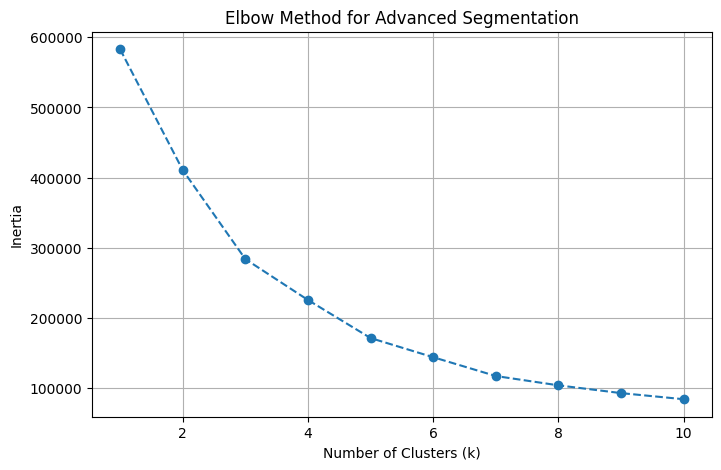


--- Analysis of Advanced Customer Segments (Mean Values) ---
                     recency  frequency    monetary  avg_review_score  \
advanced_segment                                                        
1                 247.960781   1.042950  987.858221          1.265048   
3                 141.772793   3.936109  911.692294          4.109818   
0                 393.891048   1.027367  342.450515          4.567091   
2                 130.348548   1.022115  328.011395          4.589731   

                  has_left_bad_review  avg_days_between_purchases  
advanced_segment                                                   
1                            0.999927                    0.983374  
3                            0.440775                  171.506935  
0                            0.000000                    0.553597  
2                            0.000044                    0.582981  


In [150]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 2. Scale the new feature set
scaler_segment_adv = StandardScaler()
X_segment_scaled_adv = scaler_segment_adv.fit_transform(X_segment_advanced)

# 3. Use the Elbow Method to see if the optimal 'k' has changed
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_segment_scaled_adv)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Advanced Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# 4. Train the final model with the new data
OPTIMAL_K = 4 # Let's assume 4 is still a good choice
kmeans_adv = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
customer_master_df['advanced_segment'] = kmeans_adv.fit_predict(X_segment_scaled_adv)

# 5. Analyze the new, richer segments
print("\n--- Analysis of Advanced Customer Segments (Mean Values) ---")
print(customer_master_df.groupby('advanced_segment')[feature_columns_for_segmentation].mean().sort_values('monetary', ascending=False))

## 6. Model 2: Advanced Churn Prediction (XGBoost)
This is the more sophisticated model that predicts future churn for an 'at-risk' group of customers. The purpose is to use classification algorithms to predict the probability of these customers leaving. By focusing on this specific group and hiding the `recency` feature, we force the model to use more subtle behavioral signals.


In [151]:
# 1. Identify the 'At-Risk' Customer Cohort
# These are customers who are inactive but not yet considered fully churned.
AT_RISK_LOWER_BOUND = 90
AT_RISK_UPPER_BOUND = 180

at_risk_customers_df = customer_master_df[
    (customer_master_df['recency'] > AT_RISK_LOWER_BOUND) &
    (customer_master_df['recency'] <= AT_RISK_UPPER_BOUND)
].copy()

# 2. Create the forward-looking target variable
# We want to predict who will cross the 180-day churn threshold in the next 30 days.
PREDICTION_WINDOW_DAYS = 30
at_risk_customers_df['will_churn_in_30_days'] = \
    (at_risk_customers_df['recency'] > (CHURN_THRESHOLD_DAYS - PREDICTION_WINDOW_DAYS)).astype(int)

print(f"Identified {len(at_risk_customers_df)} 'at-risk' customers for our advanced model.")

Identified 20248 'at-risk' customers for our advanced model.


In [ ]:
# 3. Define Features (X) and Target (y)
# This is the crucial step where we hide the 'recency' feature from the model.
X_advanced = at_risk_customers_df.drop(
    columns=[
        'will_churn_in_30_days',
        'customer_unique_id',
        'churn',                  # Old churn label
        'segment',                # Segmentation label from the simple model
        'advanced_segment',       # Segmentation label from the advanced model
        'recency'                 # HIDE the easy answer from the model
    ]
)
y_advanced = at_risk_customers_df['will_churn_in_30_days']

print("\nFeatures used for the advanced model:")
print(X_advanced.columns.tolist())

In [152]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# 4. Split the data before tuning
X_train, X_test, y_train, y_test = train_test_split(X_advanced, y_advanced, test_size=0.2, random_state=42, stratify=y_advanced)

# 5. Define the parameter grid for RandomizedSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.8, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 1.0]
}

# 6. Create a pipeline that includes scaling and the classifier
# We handle class imbalance with scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42))
])

# 7. Set up and run Randomized Search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    scoring='f1',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

print("\n--- Starting Hyperparameter Tuning ---")
random_search.fit(X_train, y_train)

# 8. Get the best model found by the search
print("\nBest parameters found:", random_search.best_params_)
final_churn_model = random_search.best_estimator_
print("\nAdvanced churn model training complete.")


--- Starting Hyperparameter Tuning ---
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters found: {'classifier__subsample': 1.0, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.2, 'classifier__colsample_bytree': 0.8}

Advanced churn model training complete.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:06:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Final Tuned Model Evaluation Report ---
              precision    recall  f1-score   support

           0       0.80      0.67      0.73      2673
           1       0.52      0.68      0.59      1377

    accuracy                           0.67      4050
   macro avg       0.66      0.68      0.66      4050
weighted avg       0.71      0.67      0.68      4050



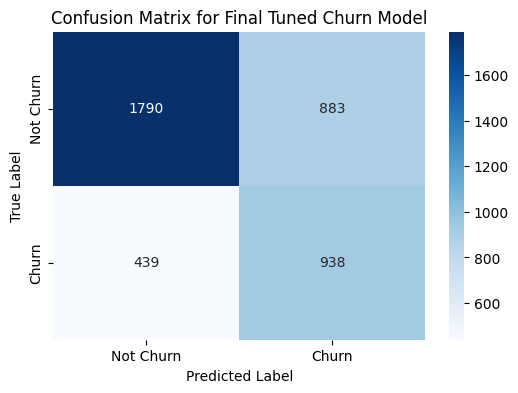

In [153]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 9. Evaluate the final tuned model on the test set
y_pred_final = final_churn_model.predict(X_test)

print("\n--- Final Tuned Model Evaluation Report ---")
print(classification_report(y_test, y_pred_final))

# Plot the confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.title('Confusion Matrix for Final Tuned Churn Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

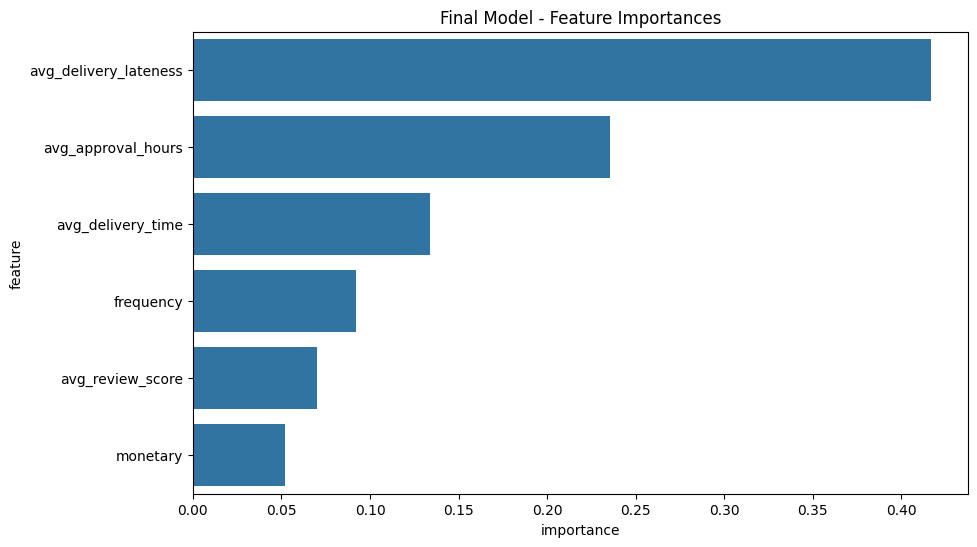

In [154]:
import pandas as pd

# 10. Interpret the final model with Feature Importance
# We need to get the classifier step from the final pipeline model
classifier_step = final_churn_model.named_steps['classifier']

feature_importances_final = pd.DataFrame({
    'feature': X_advanced.columns,
    'importance': classifier_step.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances_final)
plt.title('Final Model - Feature Importances')
plt.show()

In [155]:
from sklearn.metrics import accuracy_score

# Let's assume y_test and y_pred_final are your true labels and predicted labels
# from the final tuned model.

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred_final)

print(f"\nThe accuracy of the final tuned model is: {accuracy:.2f}")


The accuracy of the final tuned model is: 0.67


### second implementation


In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb

# Let's assume you have your data for the advanced model ready:
# X_train, X_test, y_train, y_test

# 1. Define the "base models" (our committee of experts)
# We choose a variety of models to get different perspectives on the data.
estimators = [
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# 2. Define the "meta-model" (the manager)
# Logistic Regression is a common and effective choice for the meta-model.
meta_model = LogisticRegression()

print("Base models and meta-model have been defined.")

Base models and meta-model have been defined.


In [157]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 3. Define the Stacking Classifier
# This classifier will manage the training of the base models and the final meta-model.
# cv=5 means it will use 5-fold cross-validation to generate predictions for the meta-model.
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5
)

# 4. Create the full pipeline
stacking_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('stacking', stacking_classifier)
])

# 5. Train the entire stacking pipeline
print("\n--- Starting Stacking Model Training ---")
stacking_pipeline.fit(X_train, y_train)
print("Stacking model training complete.")


--- Starting Stacking Model Training ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:12:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:12:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:12:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Stacking model training complete.



The accuracy of the Stacking model is: 0.71

--- Stacking Model Evaluation Report ---
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      2673
           1       0.63      0.38      0.47      1377

    accuracy                           0.71      4050
   macro avg       0.68      0.63      0.64      4050
weighted avg       0.70      0.71      0.69      4050



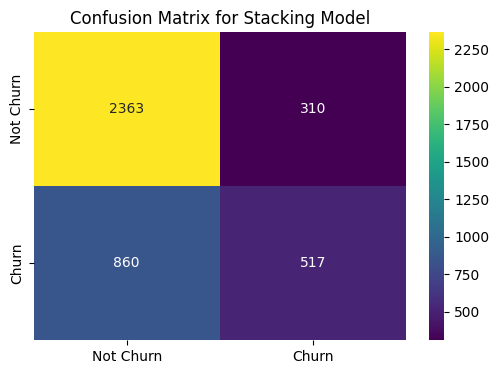

In [158]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 6. Make predictions and evaluate
y_pred_stacked = stacking_pipeline.predict(X_test)

# Calculate and print the new accuracy
accuracy_stacked = accuracy_score(y_test, y_pred_stacked)
print(f"\nThe accuracy of the Stacking model is: {accuracy_stacked:.2f}")

print("\n--- Stacking Model Evaluation Report ---")
print(classification_report(y_test, y_pred_stacked))

# Plot the new confusion matrix
cm_stacked = confusion_matrix(y_test, y_pred_stacked)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_stacked, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn']).set_title('Confusion Matrix for Stacking Model')
plt.show()

In [159]:
from sklearn.metrics import accuracy_score

# ... after making predictions ...

# Calculate and print the new accuracy
accuracy_stacked = accuracy_score(y_test, y_pred_stacked)
print(f"\nThe accuracy of the Stacking model is: {accuracy_stacked:.2f}")


The accuracy of the Stacking model is: 0.71


##third one

--- Advanced Model Evaluation Report ---
              precision    recall  f1-score   support

           0       0.79      0.70      0.74      2673
           1       0.52      0.64      0.58      1377

    accuracy                           0.68      4050
   macro avg       0.66      0.67      0.66      4050
weighted avg       0.70      0.68      0.68      4050


--- Confusion Matrix ---


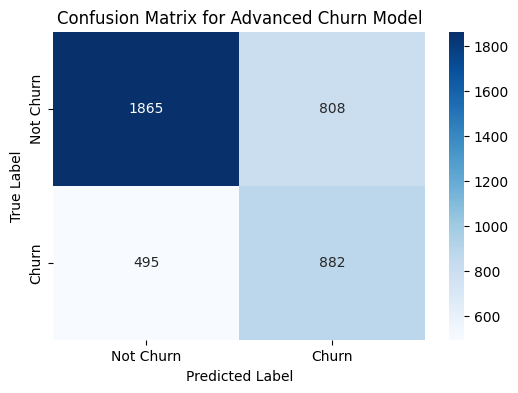

In [141]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 5. Evaluate the Advanced Model
print("--- Advanced Model Evaluation Report ---")
y_pred_advanced = advanced_churn_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred_advanced))

print("\n--- Confusion Matrix ---")
cm_advanced = confusion_matrix(y_test, y_pred_advanced)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_advanced, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.title('Confusion Matrix for Advanced Churn Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

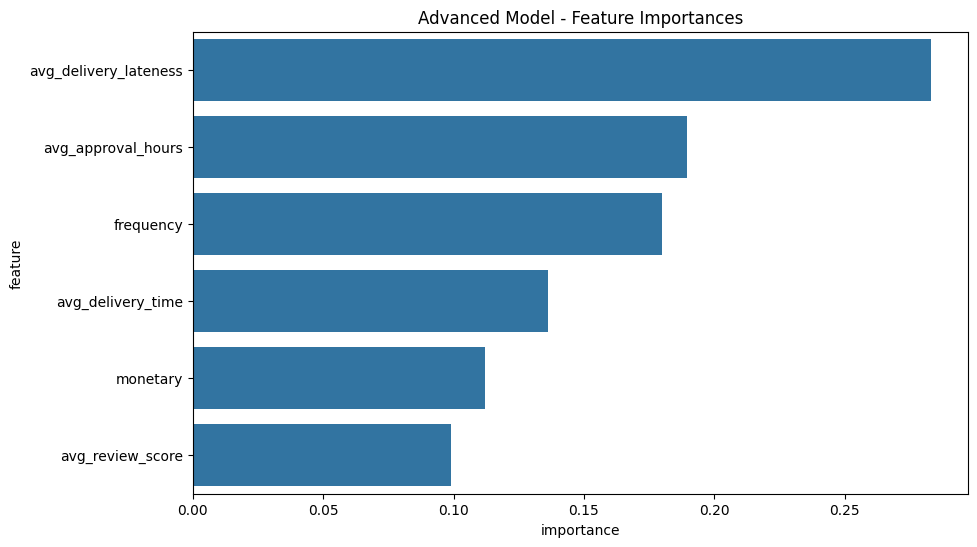

In [142]:
# 6. Interpret the Advanced Model with Feature Importance
feature_importances_advanced = pd.DataFrame({
    'feature': X_advanced.columns,
    'importance': advanced_churn_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances_advanced)
plt.title('Advanced Model - Feature Importances')
plt.show()

In [143]:
from sklearn.metrics import accuracy_score

# Let's assume y_test and y_pred_advanced are your true labels and predicted labels

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred_advanced)

print(f"The accuracy of the model is: {accuracy:.2f}")

The accuracy of the model is: 0.68


## 7. Model 3: Sales Forecasting (Prophet)
The objective of this model is to forecast sales trends to help with inventory and resource planning.

*Note: While the original presentation mentioned Linear Regression, we are using Facebook Prophet as it is a modern time-series model specifically designed to handle business forecasting challenges like seasonality and trends.*

In [162]:
# Install prophet library
!pip install prophet -q

from prophet import Prophet
import matplotlib.pyplot as plt

print("--- Implementing Sales Forecasting Model ---")

# 1. Prepare the Time-Series Data
# We need a dataframe with two columns: 'ds' (for the date) and 'y' (for the value to forecast).
# We use the augmented_df to have a richer dataset.
sales_df = augmented_df[['order_purchase_timestamp', 'payment_value']].copy()
sales_df.rename(columns={'order_purchase_timestamp': 'ds', 'payment_value': 'y'}, inplace=True)

# Aggregate total sales value for each day
daily_sales_df = sales_df.set_index('ds').resample('D').sum().reset_index()

print("\nDaily sales data prepared for Prophet:")
print(daily_sales_df.head())

--- Implementing Sales Forecasting Model ---

Daily sales data prepared for Prophet:
          ds            y
0 2016-09-04   760.970578
1 2016-09-05   689.061334
2 2016-09-06  2132.354881
3 2016-09-07  3193.604501
4 2016-09-08  1997.571546


In [163]:
# 2. Train the Prophet Model
# Prophet is straightforward to use. It automatically detects trends and seasonalities from the data.
prophet_model = Prophet()
prophet_model.fit(daily_sales_df)
print("\nProphet model training complete.")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbf7e5jeb/vvfqt5jv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbf7e5jeb/n5iwoc1s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43824', 'data', 'file=/tmp/tmpbf7e5jeb/vvfqt5jv.json', 'init=/tmp/tmpbf7e5jeb/n5iwoc1s.json', 'output', 'file=/tmp/tmpbf7e5jeb/prophet_model0j81smee/prophet_model-20251013152621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:26:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:26:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet model training complete.



Plotting the sales forecast...


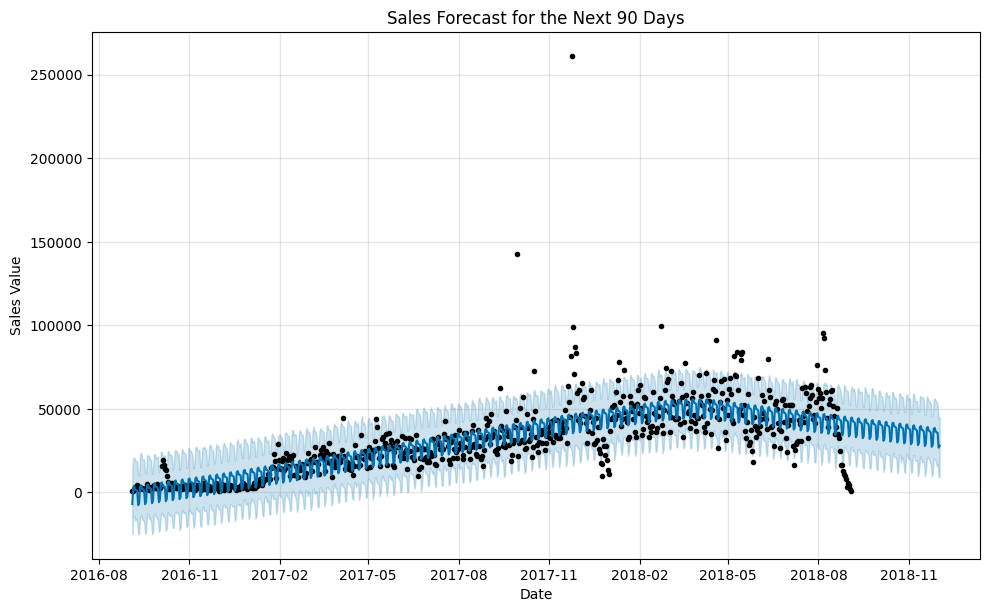

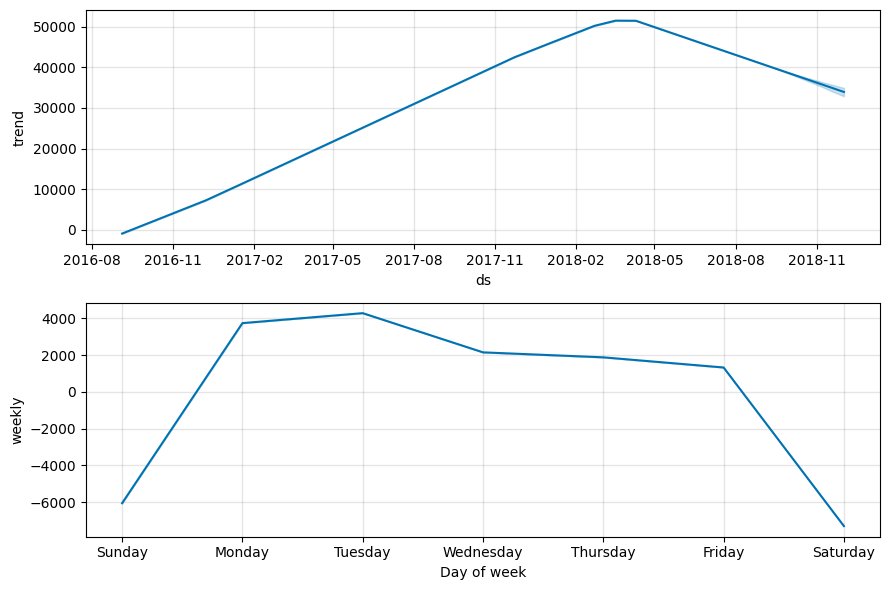

In [164]:
# 3. Make Future Predictions
# Create a dataframe for the next 90 days of predictions
future = prophet_model.make_future_dataframe(periods=90)
forecast = prophet_model.predict(future)

print("\nPlotting the sales forecast...")

# Plot the overall forecast
# Prophet's plot function shows historical points, the forecast line, and the uncertainty interval.
fig1 = prophet_model.plot(forecast)
plt.title('Sales Forecast for the Next 90 Days')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.show()

# Plot the forecast components (trend, weekly/yearly seasonality)
# This helps you understand the patterns the model has learned.
fig2 = prophet_model.plot_components(forecast)
plt.show()


### Interpreting the Forecast

* The first plot shows your historical sales (black dots), the model's forecast (blue line), and the uncertainty interval (light blue shaded area).
* The second plot breaks the forecast down into its components: the overall **trend**, **weekly seasonality** (e.g., sales are highest on certain days of the week), and **yearly seasonality** (e.g., sales peak during the holiday season).

This forecast is the final output of this model.

### Model 4: Product Return Likelihood (Random Forest)
For this model, we'll predict the likelihood of a product being returned. [cite_start]As stated in the presentation, we'll use a Random Forest model[cite: 46]. We will use the original rich `df` (before augmentation) to access detailed product features and use a low `review_score` as a proxy for a return.

In [166]:
import pandas as pd
import numpy as np

# We will use the original, rich 'df' (before augmentation) to access detailed product features.
print("--- Implementing Product Return Likelihood Model ---")

# 1. Select relevant features for predicting returns.
feature_columns_for_return = [
    'review_score', 'price', 'freight_value', 'product_category_name',
    'product_name_lenght', 'product_description_lenght', 'product_photos_qty',
    'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'
]
return_df = df[feature_columns_for_return].copy()

# For simplicity, we'll drop rows with any remaining missing values in this subset.
return_df.dropna(inplace=True)

# 2. Engineer the Target Variable.
# We'll define a "likely return" as a product that received a review score of 1 or 2.
return_df['is_likely_return'] = (return_df['review_score'] <= 2).astype(int)

# Drop the original review_score to prevent data leakage, as it was used to create the target.
return_df = return_df.drop(columns=['review_score'])

print("\nData prepared for return prediction model. Target variable 'is_likely_return' created.")
print("Distribution of target variable:")
print(return_df['is_likely_return'].value_counts())

--- Implementing Product Return Likelihood Model ---

Data prepared for return prediction model. Target variable 'is_likely_return' created.
Distribution of target variable:
is_likely_return
0    98390
1    18939
Name: count, dtype: int64


In [167]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 3. Define Features (X) and Target (y)
X_return = return_df.drop('is_likely_return', axis=1)
y_return = return_df['is_likely_return']

# 4. Identify numerical and categorical features for preprocessing
numerical_features_ret = X_return.select_dtypes(include=np.number).columns.tolist()
categorical_features_ret = ['product_category_name']

# 5. Create a preprocessor to handle different data types
return_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_ret),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_ret)
    ])

# 6. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_return, y_return, test_size=0.2, random_state=42, stratify=y_return)

print(f"\nTraining set has {X_train.shape[0]} samples.")
print(f"Testing set has {X_test.shape[0]} samples.")


Training set has 93863 samples.
Testing set has 23466 samples.



Training the Random Forest model...
Model training complete.

--- Product Return Model Evaluation Report ---
              precision    recall  f1-score   support

           0       0.89      0.90      0.90     19678
           1       0.45      0.41      0.43      3788

    accuracy                           0.82     23466
   macro avg       0.67      0.65      0.66     23466
weighted avg       0.82      0.82      0.82     23466


--- Confusion Matrix ---


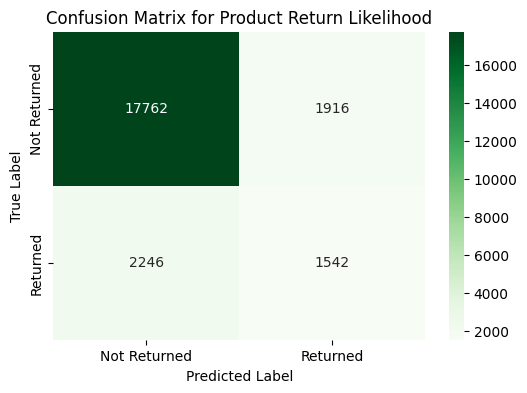

In [168]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 7. Build the full pipeline with the preprocessor and Random Forest classifier
# Use class_weight='balanced' because there are fewer "returns" than non-returns.
return_pipeline = Pipeline(steps=[
    ('preprocessor', return_preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

# 8. Train the model
print("\nTraining the Random Forest model...")
return_pipeline.fit(X_train, y_train)
print("Model training complete.")

# 9. Evaluate the model on the test set
print("\n--- Product Return Model Evaluation Report ---")
y_pred = return_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
print("\n--- Confusion Matrix ---")
cm_return = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_return, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Returned', 'Returned'],
            yticklabels=['Not Returned', 'Returned'])
plt.title('Confusion Matrix for Product Return Likelihood')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [169]:
from sklearn.metrics import accuracy_score

# Let's assume y_test and y_pred are your true and predicted labels from the return model.

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

print(f"\nThe accuracy of the Product Return Likelihood model is: {accuracy:.2f}")


The accuracy of the Product Return Likelihood model is: 0.82
